<a href="https://colab.research.google.com/github/swapniladnak2510/Transfer-learning-with-InceptionV3/blob/master/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swapniladnak","key":"7871b5a684a3cc1e4063cc309d193a42"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 24.5MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.0MB/s]


In [6]:
!unzip -q /content/chest-xray-pneumonia.zip

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-01-31 11:15:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.2.112, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  72.9MB/s    in 1.1s    

2021-01-31 11:15:20 (72.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [8]:
import tensorflow as tf
import os
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

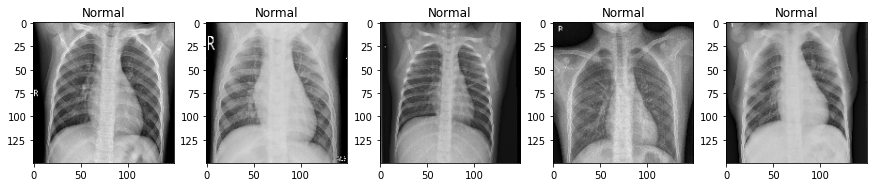

In [ ]:
j=1
plt.figure(figsize=(15,15))
for im in glob('/content/chest_xray/test/NORMAL/*')[:5]:
  ax = plt.subplot(5,5,j)
  i=tf.keras.preprocessing.image.load_img(im,target_size=(150,150,3))
  plt.imshow(i)
  plt.title('Normal')
  j=j+1

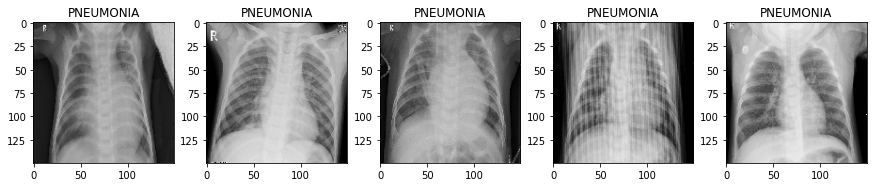

In [ ]:
j=1
plt.figure(figsize=(15,15))
for im in glob('/content/chest_xray/test/PNEUMONIA/*')[:5]:
  ax = plt.subplot(5,5,j)
  i=tf.keras.preprocessing.image.load_img(im,target_size=(150,150,3))
  plt.imshow(i)
  plt.title('PNEUMONIA')
  j=j+1

In [ ]:
#For safe side
'''model=tf.keras.Sequential([
      tf.keras.layers.Conv2D(512,(3,3),input_shape=(224,224,3),activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(512,activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(1,activation='sigmoid')
])'''

In [9]:
model=InceptionV3(include_top=False,weights=None,input_shape=(250,250,3))

In [10]:
model.load_weights("/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [11]:
for layers in model.layers:
  layers.trainable=False

In [12]:
output=model.get_layer('mixed7')

In [13]:
output=output.output

In [14]:
a=tf.keras.layers.Flatten()(output)
a=tf.keras.layers.Dense(512,activation='relu',input_shape=(250,250,3))(a)
a=tf.keras.layers.Dense(128,activation='relu')(a)
tf.keras.layers.Dropout(0.2)(a)
a=tf.keras.layers.Dense(128,activation='relu')(a)
a=tf.keras.layers.BatchNormalization()(a)
a=tf.keras.layers.Dense(64,activation='relu')(a)
a=tf.keras.layers.Dense(64,activation='relu')(a)
a=tf.keras.layers.Dense(32,activation='relu')(a)
a=tf.keras.layers.Dropout(0.2)(a)
a=tf.keras.layers.Dense(1,activation='sigmoid')(a)

In [15]:
model=Model(model.input,a)

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','Recall'])

In [17]:
train_dir='/content/chest_xray/train'
test_dir='/content/chest_xray/test'
val_dir='/content/chest_xray/val'

In [ ]:
train_norm=len(os.listdir('/content/chest_xray/train/NORMAL'))

In [ ]:
train_pneu=len(os.listdir('/content/chest_xray/train/PNEUMONIA'))

In [ ]:
res=['Normal' for i in range(train_norm)]
res.extend(['PNEUMONIA' for i in range(train_pneu)])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


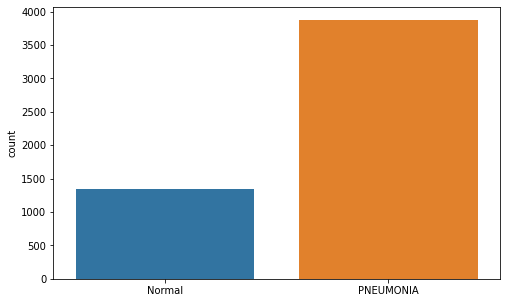

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(res)

In [18]:
train_gen=ImageDataGenerator(rescale=1/255,zoom_range=0.3)
test_gen=ImageDataGenerator(rescale=1/255)
valid_gen=ImageDataGenerator(rescale=1/255)

In [19]:
train=train_gen.flow_from_directory(train_dir,class_mode='binary',target_size=(250,250))
test=test_gen.flow_from_directory(test_dir,class_mode='binary',target_size=(250,250))
valid=valid_gen.flow_from_directory(val_dir,class_mode='binary',target_size=(250,250))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [20]:
out=model.fit(train,epochs=10,validation_data=valid,batch_size=30,verbose=1)

Epoch 1/10
163/163 [==============================] - 119s 671ms/step - loss: 0.2606 - accuracy: 0.8962 - recall: 0.9375 - val_loss: 2.0799 - val_accuracy: 0.6250 - val_recall: 1.0000
Epoch 2/10
163/163 [==============================] - 107s 658ms/step - loss: 0.0903 - accuracy: 0.9656 - recall: 0.9718 - val_loss: 0.0420 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 3/10
163/163 [==============================] - 108s 662ms/step - loss: 0.0794 - accuracy: 0.9732 - recall: 0.9798 - val_loss: 1.3575 - val_accuracy: 0.6875 - val_recall: 1.0000
Epoch 4/10
163/163 [==============================] - 106s 650ms/step - loss: 0.0734 - accuracy: 0.9736 - recall: 0.9833 - val_loss: 0.2931 - val_accuracy: 0.9375 - val_recall: 1.0000
Epoch 5/10
163/163 [==============================] - 107s 653ms/step - loss: 0.0785 - accuracy: 0.9726 - recall: 0.9772 - val_loss: 0.8337 - val_accuracy: 0.6875 - val_recall: 1.0000
Epoch 6/10
163/163 [==============================] - 106s 652ms/step - loss: 0.

In [21]:
model.evaluate(test)

20/20 [==============================] - 6s 280ms/step - loss: 0.2305 - accuracy: 0.9311 - recall: 0.9308


[0.2305218130350113, 0.9310897588729858, 0.9307692050933838]

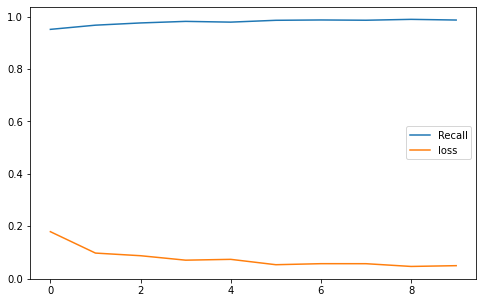

In [22]:
plt.figure(figsize=(8,5))
acc=out.history['recall']
loss=out.history['loss']
plt.plot(range(10),acc,label='Recall')
plt.plot(range(10),loss,label='loss')
plt.legend()

In [23]:
true=[]
for i in test.index_array:
  true.append(test.labels[i])

In [24]:
pred=np.round(model.predict(test))

In [25]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(true,pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       234
           1       0.96      0.93      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624



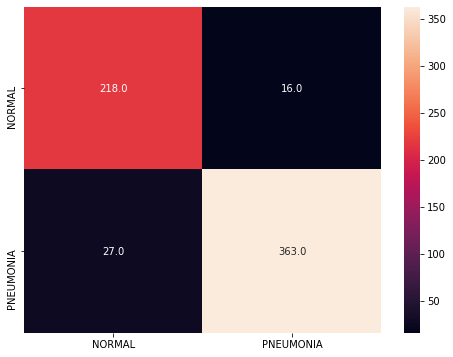

In [26]:
confusion_met=confusion_matrix(true,pred)
plt.figure(figsize=(8,6))
sns.heatmap(confusion_met,annot=True,fmt='0.1f',xticklabels=['NORMAL','PNEUMONIA'],yticklabels=['NORMAL','PNEUMONIA'])

In [29]:
res=[]
for i in glob('/content/chest_xray/test/NORMAL/*'):
  img=image.load_img(i,target_size=(250,250))
  img=image.img_to_array(img)
  img=img/255
  img=np.expand_dims(img,axis=0)
  res.append(model.predict(img))

In [ ]:
np.round(res)

In [46]:
model.save('final.h5')

In [47]:
!pip freeze > requirements.txt